In [17]:
import sys
import subprocess
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
import nltk
from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from scipy.stats import uniform, randint
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict

from scipy.stats import uniform, loguniform, randint


# Exploratory Data Analysis (EDA)

In [2]:
df=pd.read_csv("train.En.csv")
df=df[["tweet","sarcastic"]]
df.info()
print(df.head())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3468 entries, 0 to 3467
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      3467 non-null   object
 1   sarcastic  3468 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 54.3+ KB
                                               tweet  sarcastic
0  The only thing I got from college is a caffein...          1
1  I love it when professors draw a big question ...          1
2  Remember the hundred emails from companies whe...          1
3  Today my pop-pop told me I was not “forced” to...          1
4  @VolphanCarol @littlewhitty @mysticalmanatee I...          1


,sarcastic
count,3468.000000
mean,0.250000
std,0.433075
min,0.000000
25%,0.000000
50%,0.000000
75%,0.250000
max,1.000000


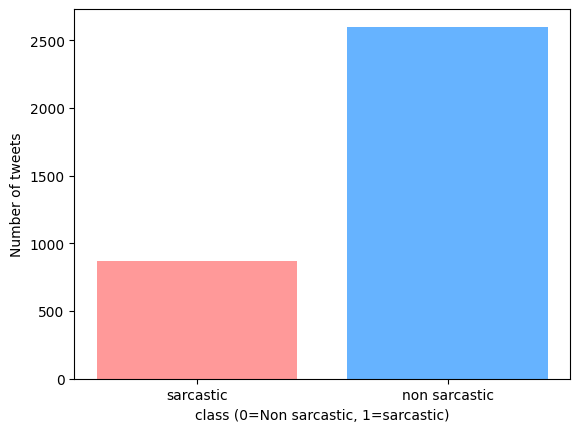

In [3]:
non_sarcastic = len(df[df["sarcastic"] == 0])
sarcastic = len(df[df["sarcastic"] == 1])

classes = ["sarcastic", "non sarcastic"]

plt.bar(classes, [sarcastic, non_sarcastic], color=['#ff9999', '#66b3ff'])
plt.xlabel("class (0=Non sarcastic, 1=sarcastic)")
plt.ylabel("Number of tweets")
plt.show()

Tweet length statistics:
           n_chars      n_words
count  3468.000000  3468.000000
mean    104.258939    18.827855
std      63.500597    11.279779
min       0.000000     0.000000
25%      57.000000    10.000000
50%      91.000000    16.500000
75%     136.000000    25.000000
max     397.000000    61.000000

Average length by class:
              n_chars    n_words
sarcastic                       
0          105.640523  19.004998
1          100.114187  18.296424


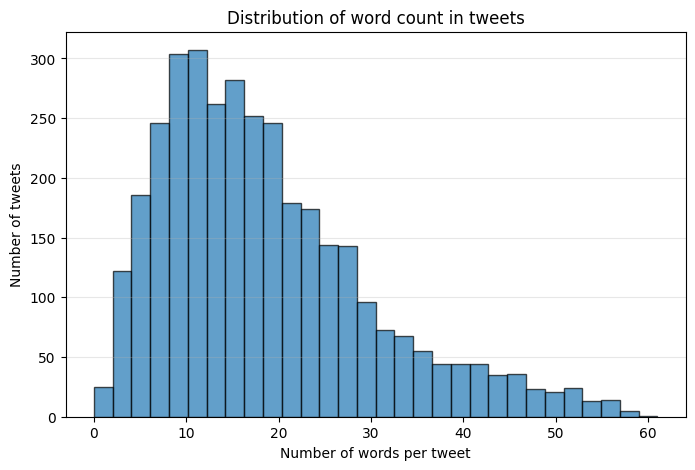

In [4]:
# Clean tweets by filling missing values
df['tweet'] = df['tweet'].fillna("")

# Calculate tweet length metrics
df['n_chars'] = df['tweet'].str.len()
df['n_words'] = df['tweet'].str.split().apply(len)

# Display tweet length statistics
print("Tweet length statistics:")
print(df[['n_chars', 'n_words']].describe())

# Display average length by sarcasm class
print("\nAverage length by class:")
print(df.groupby('sarcastic')[['n_chars', 'n_words']].mean())

# Create histogram for word count distribution
plt.figure(figsize=(8, 5))
plt.hist(df['n_words'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Number of words per tweet')
plt.ylabel('Number of tweets')
plt.title('Distribution of word count in tweets')
plt.grid(axis='y', alpha=0.3)
plt.show()

## worldcloud

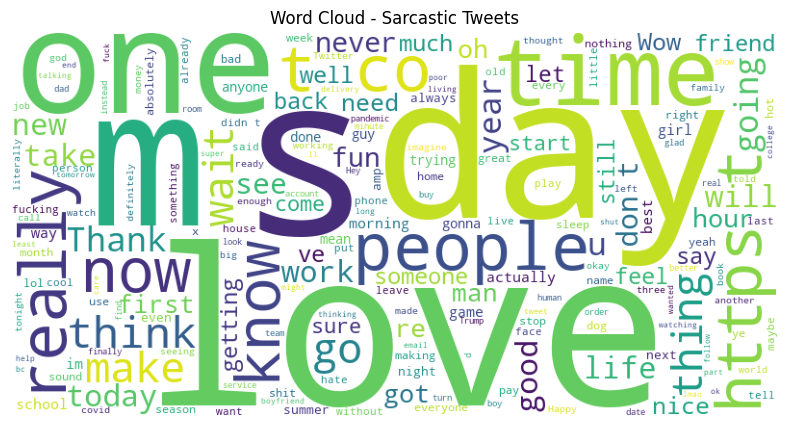

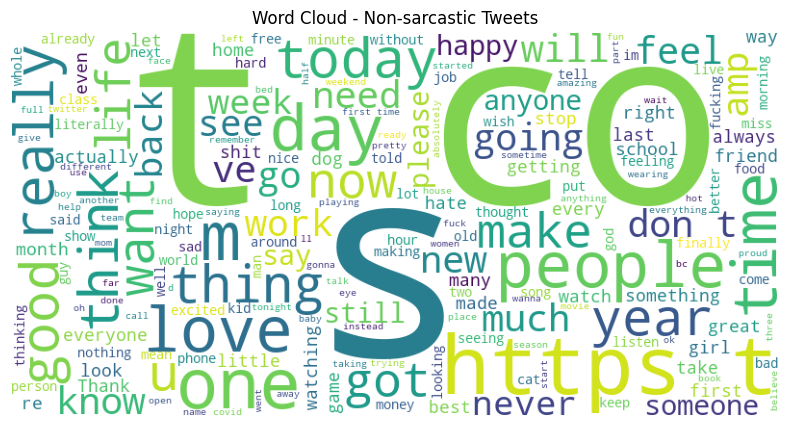

In [5]:
# Generate word cloud for sarcastic tweets
text_sarcastic = " ".join(df[df['sarcastic'] == 1]['tweet'])
wc_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(text_sarcastic)

plt.figure(figsize=(10, 5))
plt.imshow(wc_sarcastic)
plt.axis('off')
plt.title('Word Cloud - Sarcastic Tweets')
plt.show()

# Generate word cloud for non-sarcastic tweets
text_nonsarcastic = " ".join(df[df['sarcastic'] == 0]['tweet'])
wc_nonsarcastic = WordCloud(width=800, height=400, background_color='white').generate(text_nonsarcastic)

plt.figure(figsize=(10, 5))
plt.imshow(wc_nonsarcastic)
plt.axis('off')
plt.title('Word Cloud - Non-sarcastic Tweets')
plt.show()

# Text Preprocessing


In [6]:

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

def preprocess_text(text):
    """
    Minimal preprocessing optimized for RoBERTa on tweets (sarcasm detection)
    - Remove URLs only
    - Anonymize mentions (@username -> @user)
    - Clean hashtags (#word -> word)
    - Keep everything else: punctuation, capitalization, emojis, repetitions, etc.
    """
    if not isinstance(text, str) or pd.isna(text):
        return ""
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '@user', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text



df['text_clean'] = df['tweet'].fillna('').apply(preprocess_text)


df = df[df['text_clean'].str.strip() != ''].reset_index(drop=True)

print(f"Dataset after preprocessing: {len(df)} examples")


print("\nExample before/after preprocessing:")
example_idx = 0  
print("Original :", df['tweet'].iloc[example_idx])
print("Cleaned  :", df['text_clean'].iloc[example_idx])


print("\nClass distribution after cleaning:")
print(df['sarcastic'].value_counts().to_dict())

Dataset after preprocessing: 3466 examples

Example before/after preprocessing:
Original : The only thing I got from college is a caffeine addiction
Cleaned  : The only thing I got from college is a caffeine addiction

Class distribution after cleaning:
{0: 2599, 1: 867}


# Vectorization

In [7]:

print("Loading model twitter-roberta-base-sentiment-latest...")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModel.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
print("Model loaded on: {}".format(device))
print("Ready for embedding extraction!\n")

def get_roberta_embeddings_df(df, text_col='text_clean', batch_size=64, max_length=128, pooling='mean'):
    texts = df[text_col].tolist()
    embeddings_list = []
    
    print("Extracting embeddings for {} texts (batch_size={}, max_length={})...".format(len(texts), batch_size, max_length))
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Embeddings", unit="batch"):
        batch = texts[i:i + batch_size]
        
        encoded = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        
        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden_state = outputs.last_hidden_state
            
            if pooling == 'mean':
                masked_output = last_hidden_state * attention_mask.unsqueeze(-1)
                summed = masked_output.sum(1)
                lengths = attention_mask.sum(1, keepdim=True)
                embeddings = summed / lengths
            else:
                embeddings = last_hidden_state[:, 0, :]
            
            embeddings_list.append(embeddings.cpu().numpy())
    
    final_embeddings = np.concatenate(embeddings_list, axis=0)
    print("Extraction complete! Final shape: {}".format(final_embeddings.shape))
    return final_embeddings

print("\n" + "="*60)
print("EMBEDDING EXTRACTION - TRAIN SET")
print("="*60)

embeddings = get_roberta_embeddings_df(
    df, 
    text_col='text_clean', 
    batch_size=64, 
    max_length=128, 
    pooling='mean'
)

labels = df['sarcastic'].values.astype(int)

print("\nTrain embeddings shape: {}".format(embeddings.shape))
print("Labels shape          : {}".format(labels.shape))
print("Sarcastic examples    : {} / {} ({:.1f}%)".format(np.sum(labels), len(labels), np.mean(labels)*100))

Loading model twitter-roberta-base-sentiment-latest...
Model loaded on: cpu
Ready for embedding extraction!


EMBEDDING EXTRACTION - TRAIN SET
Extracting embeddings for 3466 texts (batch_size=64, max_length=128)...


Embeddings: 100%|██████████| 55/55 [02:11<00:00,  2.39s/batch]

Extraction complete! Final shape: (3466, 768)

Train embeddings shape: (3466, 768)
Labels shape          : (3466,)
Sarcastic examples    : 867 / 3466 (25.0%)


# Train and validation split

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    embeddings, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)


# Training with 5 algorithms

## 1 logisticRegression

In [10]:
print("Applying StandardScaler on embeddings...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("\n" + "="*80)
print("GRID SEARCH - Logistic Regression with extended hyperparameters")
print("="*80)

lr_base = LogisticRegression(
    max_iter=2000,
    random_state=42,
    class_weight='balanced' 
)

param_grid_lr = {
    'C': loguniform(1e-3, 100),          
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['saga'],                
    'l1_ratio': uniform(0, 1),             
    'tol': [1e-4, 1e-3, 1e-2],
    'fit_intercept': [True, False]
}
grid_lr = RandomizedSearchCV(
    estimator=lr_base,
    param_distributions=param_grid_lr,
    n_iter=60,                  
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    refit=True
)

grid_lr.fit(X_train_scaled, y_train)

print("\nBest hyperparameters: {}".format(grid_lr.best_params_))
print("Best CV F1-score: {:.4f}".format(grid_lr.best_score_))
print("Best CV accuracy: {:.4f}".format(grid_lr.best_score_))

best_lr = grid_lr.best_estimator_
y_pred_val = best_lr.predict(X_val_scaled)
y_pred_proba = best_lr.predict_proba(X_val_scaled)[:, 1]

val_acc = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val)

print("\nValidation Metrics:")
print("="*40)
print("Accuracy: {:.4f}".format(val_acc))
print("F1-score: {:.4f}".format(val_f1))
print("Precision: {:.4f}".format(precision_score(y_val, y_pred_val)))
print("Recall: {:.4f}".format(recall_score(y_val, y_pred_val)))

print("\nClassification Report:")
print("="*40)
print(classification_report(y_val, y_pred_val, target_names=['Non-sarcastic', 'Sarcastic']))

print("\nConfusion Matrix:")
print("="*40)
print(confusion_matrix(y_val, y_pred_val))

models_results = []

models_results.append({
    'model': 'Logistic Regression (optimized)',
    'estimator': best_lr,
    'scaler': scaler,
    'best_params': grid_lr.best_params_,
    'val_acc': val_acc,
    'val_f1': val_f1,
    'cv_score': grid_lr.best_score_,
    'feature_importance': best_lr.coef_[0] if hasattr(best_lr, 'coef_') else None
})

print("\n" + "="*80)
print("SUMMARY")
print("="*80)
for result in models_results:
    print("{:<50} | Acc: {:.4f} | F1: {:.4f} | CV F1: {:.4f}".format(
        result['model'], 
        result['val_acc'], 
        result['val_f1'],
        result['cv_score']
    ))
    print("Best parameters: {}".format(result['best_params']))

Applying StandardScaler on embeddings...

GRID SEARCH - Logistic Regression with extended hyperparameters
Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best hyperparameters: {'C': np.float64(0.0021108687745110266), 'fit_intercept': False, 'l1_ratio': np.float64(0.9624472949421112), 'penalty': 'l2', 'solver': 'saga', 'tol': 0.01}
Best CV F1-score: 0.4998
Best CV accuracy: 0.4998

Validation Metrics:
Accuracy: 0.6455
F1-score: 0.5233
Precision: 0.3947
Recall: 0.7759

Classification Report:
               precision    recall  f1-score   support

Non-sarcastic       0.89      0.60      0.72       520
    Sarcastic       0.39      0.78      0.52       174

     accuracy                           0.65       694
    macro avg       0.64      0.69      0.62       694
 weighted avg       0.77      0.65      0.67       694


Confusion Matrix:
[[313 207]
 [ 39 135]]

SUMMARY
Logistic Regression (optimized)                    | Acc: 0.6455 | F1: 0.5233 | CV F1: 0.4998
Best paramet

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


## 2 svm

In [11]:


print("Applying StandardScaler on embeddings (for SVM)...")
scaler_svm = StandardScaler()
X_train_scaled_svm = scaler_svm.fit_transform(X_train)
X_val_scaled_svm = scaler_svm.transform(X_val)

print("\n" + "="*80)
print("GRID SEARCH - SVM (LinearSVC) with extended parameters")
print("="*80)

svm_base = LinearSVC(
    random_state=42,
    max_iter=10000,
    dual='auto',
    class_weight='balanced'
)


param_grid_svm = {
    'C': [0.01, 0.1, 1, 10, 100],              
    'penalty': ['l2'],                        
    'loss': ['squared_hinge'],                 
    'tol': [1e-4, 1e-3],                       
    'fit_intercept': [True]   
}

grid_svm = GridSearchCV(
    estimator=svm_base,
    param_grid=param_grid_svm,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    refit=True
)

grid_svm.fit(X_train_scaled_svm, y_train)

print("\nBest hyperparameters: {}".format(grid_svm.best_params_))
print("Best CV F1-score: {:.4f}".format(grid_svm.best_score_))

best_svm = grid_svm.best_estimator_
y_pred_val = best_svm.predict(X_val_scaled_svm)

val_acc = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val)

print("\nValidation Metrics:")
print("="*40)
print("Accuracy: {:.4f}".format(val_acc))
print("F1-score: {:.4f}".format(val_f1))
print("Precision: {:.4f}".format(precision_score(y_val, y_pred_val)))
print("Recall: {:.4f}".format(recall_score(y_val, y_pred_val)))

print("\nClassification Report:")
print("="*40)
print(classification_report(y_val, y_pred_val, target_names=['Non-sarcastic', 'Sarcastic']))

models_results.append({
    'model': 'SVM (LinearSVC)',
    'estimator': best_svm,
    'scaler': scaler_svm,
    'best_params': grid_svm.best_params_,
    'sampling_method': 'None',
    'val_acc': val_acc,
    'val_f1': val_f1,
    'cv_score': grid_svm.best_score_,
    'feature_importance': best_svm.coef_[0] if hasattr(best_svm, 'coef_') else None
})

print("\n" + "="*80)
print("SVM SUMMARY")
print("="*80)
svm_results = [r for r in models_results if 'SVM' in r['model']]
for result in svm_results:
    print("{:<50} | Acc: {:.4f} | F1: {:.4f} | CV F1: {:.4f}".format(
        result['model'], 
        result['val_acc'], 
        result['val_f1'],
        result['cv_score']
    ))
    print("Best parameters: {}".format(result['best_params']))

Applying StandardScaler on embeddings (for SVM)...

GRID SEARCH - SVM (LinearSVC) with extended parameters
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best hyperparameters: {'C': 0.01, 'fit_intercept': True, 'loss': 'squared_hinge', 'penalty': 'l2', 'tol': 0.0001}
Best CV F1-score: 0.4617

Validation Metrics:
Accuracy: 0.6844
F1-score: 0.4798
Precision: 0.4089
Recall: 0.5805

Classification Report:
               precision    recall  f1-score   support

Non-sarcastic       0.84      0.72      0.77       520
    Sarcastic       0.41      0.58      0.48       174

     accuracy                           0.68       694
    macro avg       0.62      0.65      0.63       694
 weighted avg       0.73      0.68      0.70       694


SVM SUMMARY
SVM (LinearSVC)                                    | Acc: 0.6844 | F1: 0.4798 | CV F1: 0.4617
Best parameters: {'C': 0.01, 'fit_intercept': True, 'loss': 'squared_hinge', 'penalty': 'l2', 'tol': 0.0001}


# 3 random forest

In [16]:


print("\n" + "="*80)
print("GRID SEARCH - Random Forest Classifier with extended parameters")
print("="*80)

rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample'
)


param_grid_rf = {
    'n_estimators': [200, 300, 500],          
    'max_depth': [None, 15, 25, 35],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],               
    'max_features': ['sqrt', 'log2'],  
    'bootstrap': [True],                 
    'criterion': ['gini']       
   
}

grid_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    refit=True
)

grid_rf.fit(X_train, y_train)

print("\nBest hyperparameters: {}".format(grid_rf.best_params_))
print("Best CV F1-score: {:.4f}".format(grid_rf.best_score_))

best_rf = grid_rf.best_estimator_
y_pred_val = best_rf.predict(X_val)
y_pred_proba = best_rf.predict_proba(X_val)[:, 1]

val_acc = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val)

print("\nValidation Metrics:")
print("="*40)
print("Accuracy: {:.4f}".format(val_acc))
print("F1-score: {:.4f}".format(val_f1))
print("Precision: {:.4f}".format(precision_score(y_val, y_pred_val)))
print("Recall: {:.4f}".format(recall_score(y_val, y_pred_val)))

print("\nClassification Report:")
print("="*40)
print(classification_report(y_val, y_pred_val, target_names=['Non-sarcastic', 'Sarcastic']))

print("\nFeature Importance (top 10):")
print("="*40)
if hasattr(best_rf, 'feature_importances_'):
    feature_importance = best_rf.feature_importances_
    top_indices = feature_importance.argsort()[-10:][::-1]
    for i, idx in enumerate(top_indices):
        print("Feature {}: {:.6f}".format(idx, feature_importance[idx]))

models_results.append({
    'model': 'Random Forest Classifier',
    'estimator': best_rf,
    'scaler': None,
    'best_params': grid_rf.best_params_,
    'sampling_method': 'None',
    'val_acc': val_acc,
    'val_f1': val_f1,
    'cv_score': grid_rf.best_score_,
    'feature_importance': best_rf.feature_importances_ if hasattr(best_rf, 'feature_importances_') else None
})

print("\n" + "="*80)
print("RANDOM FOREST SUMMARY")
print("="*80)
rf_results = [r for r in models_results if 'Random Forest' in r['model']]
for result in rf_results:
    print("{:<50} | Acc: {:.4f} | F1: {:.4f} | CV F1: {:.4f}".format(
        result['model'], 
        result['val_acc'], 
        result['val_f1'],
        result['cv_score']
    ))
    print("Best parameters: {}".format(result['best_params']))


GRID SEARCH - Random Forest Classifier with extended parameters
Fitting 5 folds for each of 96 candidates, totalling 480 fits

Best hyperparameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best CV F1-score: 0.1821

Validation Metrics:
Accuracy: 0.7622
F1-score: 0.1451
Precision: 0.7368
Recall: 0.0805

Classification Report:
               precision    recall  f1-score   support

Non-sarcastic       0.76      0.99      0.86       520
    Sarcastic       0.74      0.08      0.15       174

     accuracy                           0.76       694
    macro avg       0.75      0.54      0.50       694
 weighted avg       0.76      0.76      0.68       694


Feature Importance (top 10):
Feature 483: 0.004817
Feature 204: 0.004725
Feature 316: 0.004378
Feature 703: 0.004138
Feature 326: 0.003931
Feature 701: 0.003789
Feature 92: 0.003656
Feature 171: 0.003523
Feature 748: 0.003513
Fea

## 4 Naive Bayes

In [13]:
print("\n" + "="*80)
print("GRID SEARCH - Gaussian Naive Bayes (var_smoothing tuning)")
print("="*80)

nb_base = GaussianNB()

param_grid_nb = {
    'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

grid_nb = GridSearchCV(
    estimator=nb_base,
    param_grid=param_grid_nb,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    refit=True
)

grid_nb.fit(X_train, y_train)

print("\nBest hyperparameters: {}".format(grid_nb.best_params_))
print("Best CV F1-score: {:.4f}".format(grid_nb.best_score_))

best_nb = grid_nb.best_estimator_

y_pred_val = best_nb.predict(X_val)
y_pred_proba = best_nb.predict_proba(X_val)[:, 1]

val_acc = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val)

print("\nValidation Metrics:")
print("="*40)
print("Accuracy: {:.4f}".format(val_acc))
print("F1-score: {:.4f}".format(val_f1))
print("Precision: {:.4f}".format(precision_score(y_val, y_pred_val)))
print("Recall: {:.4f}".format(recall_score(y_val, y_pred_val)))

print("\nClassification Report:")
print("="*40)
print(classification_report(y_val, y_pred_val, target_names=['Non-sarcastic', 'Sarcastic']))

print("\nClass Priors:")
print("="*40)
print("Class 0 (Non-sarcastic): {:.4f}".format(best_nb.class_prior_[0]))
print("Class 1 (Sarcastic): {:.4f}".format(best_nb.class_prior_[1]))

print("\nSelected var_smoothing: {}".format(best_nb.var_smoothing))

print("\nFeature statistics (first 5 features):")
print("="*40)
for i in range(min(5, X_train.shape[1])):
    print("Feature {}: mean_0={:.4f}, var_0={:.4f}, mean_1={:.4f}, var_1={:.4f}".format(
        i, best_nb.theta_[0][i], best_nb.var_[0][i], best_nb.theta_[1][i], best_nb.var_[1][i]
    ))

models_results.append({
    'model': 'Gaussian Naive Bayes',
    'estimator': best_nb,
    'scaler': None,
    'best_params': grid_nb.best_params_,
    'sampling_method': 'None',
    'val_acc': val_acc,
    'val_f1': val_f1,
    'cv_score': grid_nb.best_score_,
    'feature_importance': None,
    'class_priors': best_nb.class_prior_,
    'var_smoothing': best_nb.var_smoothing
})

print("\n" + "="*80)
print("NAIVE BAYES SUMMARY")
print("="*80)
nb_results = [r for r in models_results if 'Naive Bayes' in r['model']]
for result in nb_results:
    print("{:<50} | Acc: {:.4f} | F1: {:.4f} | CV F1: {:.4f}".format(
        result['model'], 
        result['val_acc'], 
        result['val_f1'],
        result.get('cv_score', 'N/A')
    ))
    print("Best parameters: {}".format(result['best_params']))
    print("var_smoothing: {}".format(result['var_smoothing']))


GRID SEARCH - Gaussian Naive Bayes (var_smoothing tuning)
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best hyperparameters: {'var_smoothing': 1e-10}
Best CV F1-score: 0.4228

Validation Metrics:
Accuracy: 0.5375
F1-score: 0.4278
Precision: 0.3101
Recall: 0.6897

Classification Report:
               precision    recall  f1-score   support

Non-sarcastic       0.82      0.49      0.61       520
    Sarcastic       0.31      0.69      0.43       174

     accuracy                           0.54       694
    macro avg       0.57      0.59      0.52       694
 weighted avg       0.70      0.54      0.57       694


Class Priors:
Class 0 (Non-sarcastic): 0.7500
Class 1 (Sarcastic): 0.2500

Selected var_smoothing: 1e-10

Feature statistics (first 5 features):
Feature 0: mean_0=0.2113, var_0=0.0994, mean_1=0.2524, var_1=0.0932
Feature 1: mean_0=0.0866, var_0=0.1741, mean_1=0.0285, var_1=0.1801
Feature 2: mean_0=0.0391, var_0=0.0510, mean_1=0.0154, var_1=0.0504
Feature 3: me

## 5 KNN

In [14]:
scaler_knn = StandardScaler()
X_train_scaled_knn = scaler_knn.fit_transform(X_train)
X_val_scaled_knn = scaler_knn.transform(X_val)

print("\n" + "="*80)
print("GRID SEARCH - K-Nearest Neighbors")
print("="*80)

knn_base = KNeighborsClassifier(n_jobs=-1)

param_grid_knn = {
    'n_neighbors': [5, 7, 9, 11, 15, 21],         
    'weights': ['uniform', 'distance'],          
    'metric': ['euclidean', 'manhattan', 'cosine'],
    'algorithm': ['auto', 'ball_tree'],           
    'leaf_size': [20, 30, 40]             
}

grid_knn = GridSearchCV(
    estimator=knn_base,
    param_grid=param_grid_knn,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    refit=True
)

grid_knn.fit(X_train_scaled_knn, y_train)

print("\nBest hyperparameters: {}".format(grid_knn.best_params_))
print("Best CV F1-score: {:.4f}".format(grid_knn.best_score_))

best_knn = grid_knn.best_estimator_
y_pred_val = best_knn.predict(X_val_scaled_knn)

val_acc = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val)

print("\nValidation Metrics:")
print("="*40)
print("Accuracy: {:.4f}".format(val_acc))
print("F1-score: {:.4f}".format(val_f1))
print("Precision: {:.4f}".format(precision_score(y_val, y_pred_val)))
print("Recall: {:.4f}".format(recall_score(y_val, y_pred_val)))

print("\nClassification Report:")
print("="*40)
print(classification_report(y_val, y_pred_val, target_names=['Non-sarcastic', 'Sarcastic']))

models_results.append({
    'model': 'K-Nearest Neighbors',
    'estimator': best_knn,
    'scaler': scaler_knn,
    'best_params': grid_knn.best_params_,
    'sampling_method': 'None',
    'val_acc': val_acc,
    'val_f1': val_f1,
    'cv_score': grid_knn.best_score_,
    'feature_importance': None
})

print("\n" + "="*80)
print("K-NEAREST NEIGHBORS SUMMARY")
print("="*80)
knn_results = [r for r in models_results if 'K-Nearest Neighbors' in r['model']]
for result in knn_results:
    print("{:<50} | Acc: {:.4f} | F1: {:.4f} | CV F1: {:.4f}".format(
        result['model'], 
        result['val_acc'], 
        result['val_f1'],
        result['cv_score']
    ))
    print("Best parameters: {}".format(result['best_params']))


GRID SEARCH - K-Nearest Neighbors
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
180 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\ASUS\AppDat


Best hyperparameters: {'algorithm': 'auto', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best CV F1-score: 0.3019

Validation Metrics:
Accuracy: 0.7248
F1-score: 0.2568
Precision: 0.3976
Recall: 0.1897

Classification Report:
               precision    recall  f1-score   support

Non-sarcastic       0.77      0.90      0.83       520
    Sarcastic       0.40      0.19      0.26       174

     accuracy                           0.72       694
    macro avg       0.58      0.55      0.54       694
 weighted avg       0.68      0.72      0.69       694


K-NEAREST NEIGHBORS SUMMARY
K-Nearest Neighbors                                | Acc: 0.7248 | F1: 0.2568 | CV F1: 0.3019
Best parameters: {'algorithm': 'auto', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


## 6 XGBoost

In [19]:

neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1
print("Classes in train: Non-sarcastic={}, Sarcastic={}".format(neg_count, pos_count))
print("Calculated scale_pos_weight: {:.2f} (≈ {}/{})".format(scale_pos_weight, neg_count, pos_count))

print("\n" + "="*80)
print("GRID SEARCH - XGBoost Classifier - PARAMÈTRES RÉDUITS (plus rapide)")
print("="*80)

xgb_base = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)

param_dist_xgb = {
    'n_estimators': randint(200, 600),
    'max_depth': randint(4, 12),
    'learning_rate': uniform(0.01, 0.29),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'min_child_weight': randint(1, 10),
    'reg_alpha': uniform(0, 2),
    'reg_lambda': uniform(0.5, 2.5),
    'max_delta_step': uniform(0, 3)
}

grid_xgb = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist_xgb,
    n_iter=80,          
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    refit=True
)

grid_xgb.fit(X_train, y_train)

print("\nBest hyperparameters: {}".format(grid_xgb.best_params_))
print("Best CV F1-score: {:.4f}".format(grid_xgb.best_score_))

best_xgb = grid_xgb.best_estimator_
y_pred_val = best_xgb.predict(X_val)
y_pred_proba = best_xgb.predict_proba(X_val)[:, 1]

val_acc = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val)

print("\nValidation Metrics:")
print("="*40)
print("Accuracy: {:.4f}".format(val_acc))
print("F1-score: {:.4f}".format(val_f1))
print("Precision: {:.4f}".format(precision_score(y_val, y_pred_val)))
print("Recall: {:.4f}".format(recall_score(y_val, y_pred_val)))

print("\nClassification Report:")
print("="*40)
print(classification_report(y_val, y_pred_val, target_names=['Non-sarcastic', 'Sarcastic']))

print("\nFeature Importance (top 10):")
print("="*40)
feature_importance = best_xgb.feature_importances_
top_indices = feature_importance.argsort()[-10:][::-1]
for i, idx in enumerate(top_indices):
    print("Feature {}: {:.6f}".format(idx, feature_importance[idx]))

models_results.append({
    'model': 'XGBoost Classifier',
    'estimator': best_xgb,
    'scaler': None,
    'best_params': grid_xgb.best_params_,
    'sampling_method': 'scale_pos_weight',
    'val_acc': val_acc,
    'val_f1': val_f1,
    'cv_score': grid_xgb.best_score_,
    'feature_importance': feature_importance,
    'scale_pos_weight_used': scale_pos_weight
})

print("\n" + "="*80)
print("XGBOOST SUMMARY")
print("="*80)
xgb_results = [r for r in models_results if 'XGBoost' in r['model']]
for result in xgb_results:
    print("{:<50} | Acc: {:.4f} | F1: {:.4f} | CV F1: {:.4f}".format(
        result['model'], 
        result['val_acc'], 
        result['val_f1'],
        result['cv_score']
    ))
    print("Best parameters: {}".format(result['best_params']))
    print("Scale pos weight: {:.2f}".format(result['scale_pos_weight_used']))

Classes in train: Non-sarcastic=2079, Sarcastic=693
Calculated scale_pos_weight: 3.00 (≈ 2079/693)

GRID SEARCH - XGBoost Classifier - PARAMÈTRES RÉDUITS (plus rapide)
Fitting 5 folds for each of 80 candidates, totalling 400 fits

Best hyperparameters: {'colsample_bytree': np.float64(0.7275902521175045), 'gamma': np.float64(0.4224376554847273), 'learning_rate': np.float64(0.016748861363389503), 'max_delta_step': np.float64(2.4434054477668075), 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 395, 'reg_alpha': np.float64(1.3857807173838788), 'reg_lambda': np.float64(1.3708415111329935), 'subsample': np.float64(0.9746592607422829)}
Best CV F1-score: 0.4462

Validation Metrics:
Accuracy: 0.7349
F1-score: 0.4620
Precision: 0.4702
Recall: 0.4540

Classification Report:
               precision    recall  f1-score   support

Non-sarcastic       0.82      0.83      0.82       520
    Sarcastic       0.47      0.45      0.46       174

     accuracy                           0.73       6

# test final

In [20]:
print("Loading and preprocessing test set...")
df_test = pd.read_csv("task_A_En_test.csv")

df_test['text'] = df_test['text'].fillna('')
df_test['text_clean'] = df_test['text'].apply(preprocess_text)
df_test = df_test[df_test['text_clean'].str.strip() != ''].reset_index(drop=True)

y_test = df_test['sarcastic'].values.astype(int)

print("Test set ready: {} examples".format(len(df_test)))

print("\nExtracting RoBERTa embeddings for test set...")
embeddings_test = get_roberta_embeddings_df(
    df_test,
    text_col='text_clean',
    batch_size=64,
    max_length=128,
    pooling='mean'
)

print("Test embeddings shape: {}".format(embeddings_test.shape))

test_results = []

print("\n" + "="*80)
print("FINAL EVALUATION ON TEST SET")
print("="*80)

for model_info in models_results:
    model_name = model_info['model']
    estimator = model_info['estimator']
    scaler = model_info.get('scaler')
    sampling_method = model_info.get('sampling_method', 'N/A')
    
    if scaler is not None:
        X_test_prep = scaler.transform(embeddings_test)
    else:
        X_test_prep = embeddings_test
    
    y_pred = estimator.predict(X_test_prep)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    test_results.append({
        'Model': model_name,
        'Sampling Method': sampling_method,
        'F1-score': f1,
        'Accuracy': acc
    })

test_df = pd.DataFrame(test_results)
test_df = test_df.sort_values(by='F1-score', ascending=False).reset_index(drop=True)
test_df = test_df.round(4)

print("\nFINAL RESULTS ON TEST SET (Sorted by F1-score)")
print("="*80)
print(test_df.to_string(index=False))
print("="*80)

best_model = test_df.iloc[0]
print("\n🏆 BEST MODEL ON TEST SET:")
print("   Model: {}".format(best_model['Model']))
print("   Sampling Method: {}".format(best_model['Sampling Method']))
print("   F1-score: {:.4f}".format(best_model['F1-score']))
print("   Accuracy: {:.4f}".format(best_model['Accuracy']))

Loading and preprocessing test set...
Test set ready: 1400 examples

Extracting RoBERTa embeddings for test set...
Extracting embeddings for 1400 texts (batch_size=64, max_length=128)...


Embeddings: 100%|██████████| 22/22 [00:54<00:00,  2.46s/batch]


Extraction complete! Final shape: (1400, 768)
Test embeddings shape: (1400, 768)

FINAL EVALUATION ON TEST SET

FINAL RESULTS ON TEST SET (Sorted by F1-score)
                          Model  Sampling Method  F1-score  Accuracy
                SVM (LinearSVC)             None    0.3659    0.6757
             XGBoost Classifier scale_pos_weight    0.3642    0.7107
Logistic Regression (optimized)              N/A    0.3207    0.5400
       Random Forest Classifier             None    0.2955    0.8671
            K-Nearest Neighbors             None    0.2822    0.7893
           Gaussian Naive Bayes             None    0.2487    0.4993
       Random Forest Classifier             None    0.2469    0.8693

🏆 BEST MODEL ON TEST SET:
   Model: SVM (LinearSVC)
   Sampling Method: None
   F1-score: 0.3659
   Accuracy: 0.6757


# saving best model

In [21]:
import joblib
import os

print("\n" + "="*60)
print("SAVING BEST MODEL")
print("="*60)

best_model_name = best_model['Model']
best_model_info = None

for model_info in models_results:
    if model_info['model'] == best_model_name:
        best_model_info = model_info
        break

if best_model_info:
    model_dir = "best_model"
    os.makedirs(model_dir, exist_ok=True)
    
    model_path = os.path.join(model_dir, "best_model.pkl")
    joblib.dump({
        'estimator': best_model_info['estimator'],
        'scaler': best_model_info.get('scaler'),
        'model_name': best_model_info['model']
    }, model_path)
    
    print("Best model: {}".format(best_model_name))
    print("Saved to: {}".format(model_path))
    print("Test F1: {:.4f}".format(best_model['F1-score']))


SAVING BEST MODEL
Best model: SVM (LinearSVC)
Saved to: best_model\best_model.pkl
Test F1: 0.3659


# CONFUSION MATRICES


CONFUSION MATRICES - TEST SET


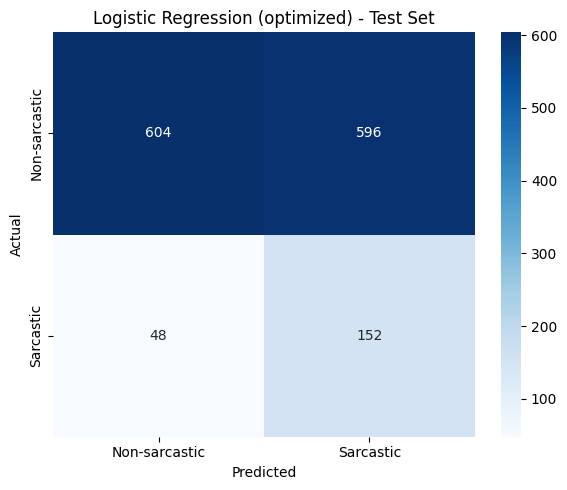


Model: Logistic Regression (optimized)
Confusion Matrix:
TN: 604 | FP: 596
FN: 48 | TP: 152
----------------------------------------


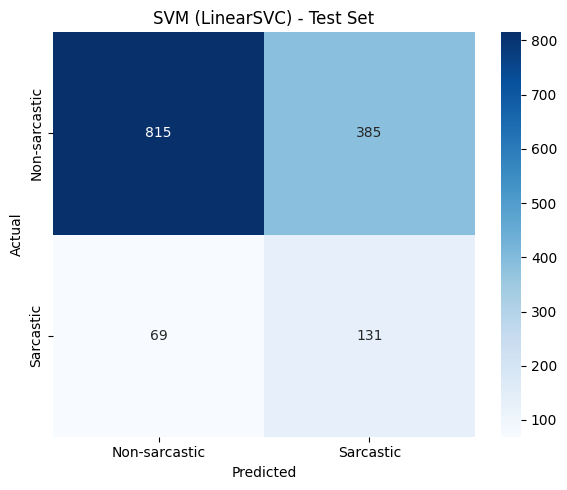


Model: SVM (LinearSVC)
Confusion Matrix:
TN: 815 | FP: 385
FN: 69 | TP: 131
----------------------------------------


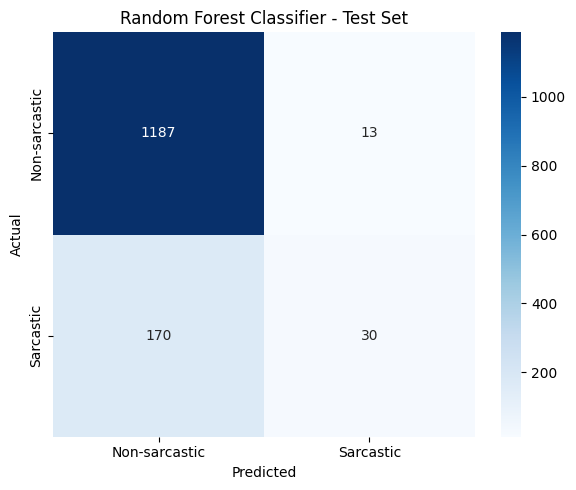


Model: Random Forest Classifier
Confusion Matrix:
TN: 1187 | FP: 13
FN: 170 | TP: 30
----------------------------------------


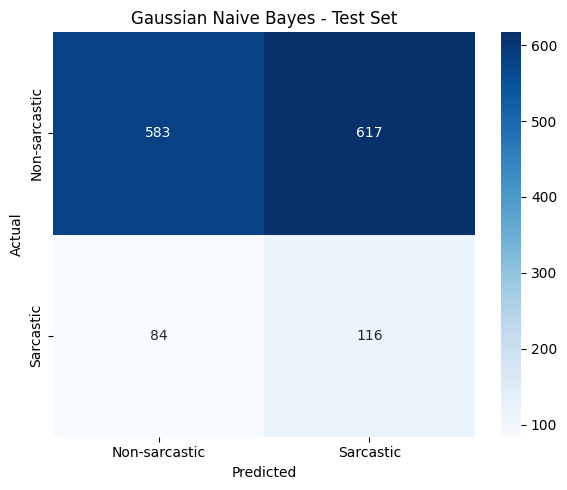


Model: Gaussian Naive Bayes
Confusion Matrix:
TN: 583 | FP: 617
FN: 84 | TP: 116
----------------------------------------


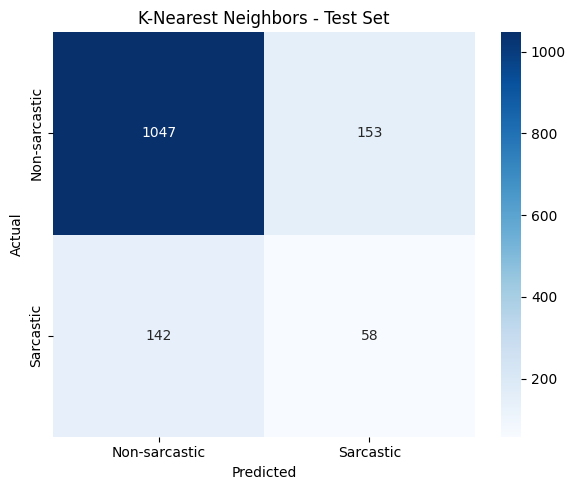


Model: K-Nearest Neighbors
Confusion Matrix:
TN: 1047 | FP: 153
FN: 142 | TP: 58
----------------------------------------


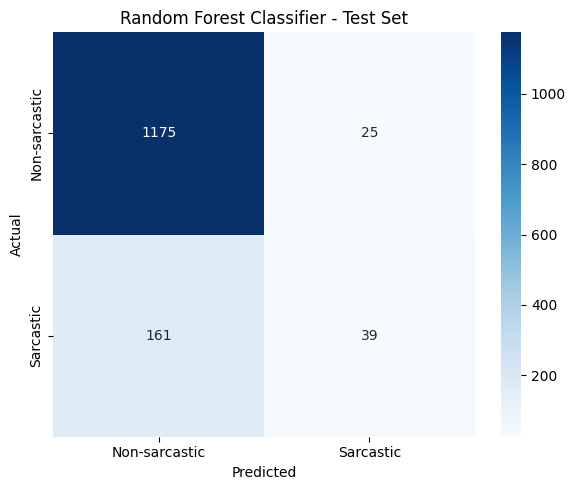


Model: Random Forest Classifier
Confusion Matrix:
TN: 1175 | FP: 25
FN: 161 | TP: 39
----------------------------------------


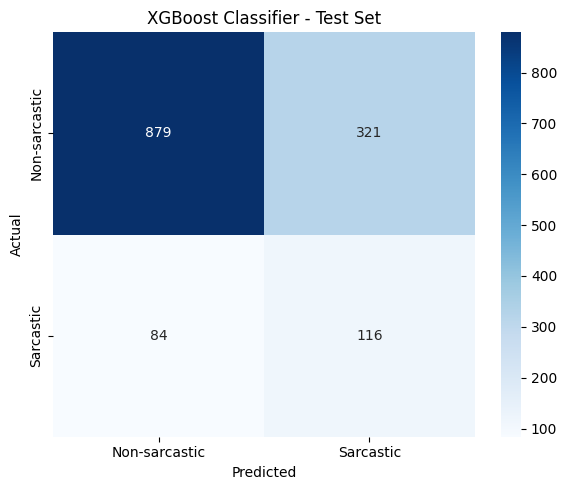


Model: XGBoost Classifier
Confusion Matrix:
TN: 879 | FP: 321
FN: 84 | TP: 116
----------------------------------------


In [22]:


print("\n" + "="*60)
print("CONFUSION MATRICES - TEST SET")
print("="*60)

for model_info in models_results:
    model_name = model_info['model']
    estimator = model_info['estimator']
    scaler = model_info.get('scaler')
    
    if scaler is not None:
        X_test_prep = scaler.transform(embeddings_test)
    else:
        X_test_prep = embeddings_test
    
    y_pred = estimator.predict(X_test_prep)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-sarcastic', 'Sarcastic'],
                yticklabels=['Non-sarcastic', 'Sarcastic'])
    plt.title('{} - Test Set'.format(model_name))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    tn, fp, fn, tp = cm.ravel()
    print("\nModel: {}".format(model_name))
    print("Confusion Matrix:")
    print("TN: {} | FP: {}".format(tn, fp))
    print("FN: {} | TP: {}".format(fn, tp))
    print("-" * 40)

# FINE-TUNING

In [23]:

subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "accelerate>=0.26.0"])
print("Installation complete. RESTART KERNEL NOW!")

print("\n" + "="*60)
print("STARTING TWITTER-ROBERTA FINE-TUNING")
print("="*60)

df_test = pd.read_csv("task_A_En_test.csv")
df_test['text_clean'] = df_test['text'].fillna('').apply(preprocess_text)
df_test = df_test[df_test['text_clean'].str.strip() != ''].reset_index(drop=True)

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['sarcastic']
)

print("\nDataset sizes:")
print("   Train : {}".format(len(train_df)))
print("   Val   : {}".format(len(val_df)))
print("   Test  : {}".format(len(df_test)))

dataset = DatasetDict({
    'train': Dataset.from_pandas(
        train_df[['text_clean', 'sarcastic']].rename(columns={'text_clean': 'text', 'sarcastic': 'label'})
    ),
    'val': Dataset.from_pandas(
        val_df[['text_clean', 'sarcastic']].rename(columns={'text_clean': 'text', 'sarcastic': 'label'})
    ),
    'test': Dataset.from_pandas(
        df_test[['text_clean', 'sarcastic']].rename(columns={'text_clean': 'text', 'sarcastic': 'label'})
    )
})

model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
print("\nLoading model: {}".format(model_name))

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

dataset = dataset.map(tokenize_function, batched=True)
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=2,
    ignore_mismatched_sizes=True
)

labels_train = train_df['sarcastic'].values
classes = np.unique(labels_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels_train)
class_weights = torch.tensor(weights, dtype=torch.float)

print("\nClass weights: Non-sarcastic={:.3f}, Sarcastic={:.3f}".format(weights[0], weights[1]))

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        weights_device = class_weights.to(logits.device)
        
        loss_fct = torch.nn.CrossEntropyLoss(weight=weights_device)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='binary')
    }

training_args = TrainingArguments(
    output_dir="./roberta_finetuned_sarcasm",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    save_total_limit=2,
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['val'],
    compute_metrics=compute_metrics,
)

print("\n" + "="*60)
print("STARTING FINE-TUNING...")
print("="*60)

trainer.train()

print("\n" + "="*60)
print("EVALUATION ON TEST SET")
print("="*60)

predictions = trainer.predict(dataset['test'])
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

final_f1 = f1_score(y_true, y_pred, average='binary')
final_acc = accuracy_score(y_true, y_pred)

print("\nFINAL RESULTS ON TEST SET:")
print("   F1-score : {:.4f}".format(final_f1))
print("   Accuracy : {:.4f}".format(final_acc))

cm = confusion_matrix(y_true, y_pred)
print("\nCONFUSION MATRIX:")
print("               Predicted Negative  Predicted Positive")
print("Actual Negative       {:4d}               {:4d}".format(cm[0,0], cm[0,1]))
print("Actual Positive       {:4d}               {:4d}".format(cm[1,0], cm[1,1]))

print("\nSaving final model...")
trainer.save_model("./roberta_final_model")
tokenizer.save_pretrained("./roberta_final_model")
print("Model saved to ./roberta_final_model")

Installation complete. RESTART KERNEL NOW!

STARTING TWITTER-ROBERTA FINE-TUNING

Dataset sizes:
   Train : 2772
   Val   : 694
   Test  : 1400

Loading model: cardiffnlp/twitter-roberta-base-sentiment-latest


Map: 100%|██████████| 1400/1400 [00:00<00:00, 21285.48 examples/s]
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized because the shapes did not match:
- classifi


Class weights: Non-sarcastic=0.667, Sarcastic=2.000

STARTING FINE-TUNING...


c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.614200,0.611551,0.742075,0.481159
2,0.445600,0.684904,0.756484,0.534435
3,0.289900,1.061527,0.780980,0.464789
4,0.182700,1.417381,0.783862,0.503311
5,0.110600,1.556332,0.788184,0.524272


c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings


EVALUATION ON TEST SET


c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



FINAL RESULTS ON TEST SET:
   F1-score : 0.3725
   Accuracy : 0.6800

CONFUSION MATRIX:
               Predicted Negative  Predicted Positive
Actual Negative        819                381
Actual Positive         67                133

Saving final model...
Model saved to ./roberta_final_model
